# Setup

In [2]:
#| code-fold: true
import math, random, matplotlib.pyplot as plt, operator, torch
from functools import partial
from fastcore.all import *
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor
plt.style.use('dark_background')

In [3]:
#| code-fold: true
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [4]:
#| code-fold: true
def plot_data(centroids:torch.Tensor,# Centroid coordinates
              data:torch.Tensor, # Data Coordinates
              n_samples:int, # Number of samples
              ax:plt.Axes=None # Matplotlib Axes object
             )-> None:
    '''Creates a visualization of centroids and data points for clustering problems'''
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

# Generate Dataset

We need to create a dataset.  This data generation step follows what Jeremy Howard did in a notebook he did on meanshift clustering, which is a different clustering algorithm.  That notebook was part of the [fast.ai](fast.ai) [2022 part 2 course](https://www.fast.ai/posts/part2-2022.html).  

Since the same dataset can be used, I used his and removed some unneeded print statements.  See the plot for what the data looks like.

In [5]:
n_clusters = 6
n_samples = 250
centroids = torch.rand(n_clusters, 2)*70-35 # Points between -35 and 35

In [6]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [7]:
data = torch.cat([sample(c) for c in centroids])

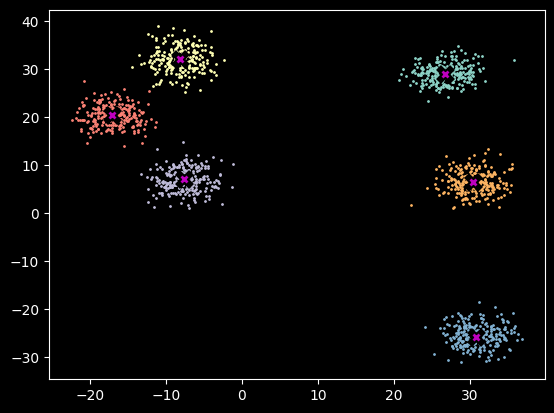

In [8]:
plot_data(centroids, data, n_samples)

# K Means

K-means is a clustering algorithm.  There's 4 main steps to the process:

    + Initialize Centroids at smart starting positions
    + Calculate distance between data points and centroids
    + Classify data points based on closes centroid
    + Update centroids by moving them toward the mean of its points

Once you have those steps, you can repeat the last 3 until your centroids no longer move.

## Calculate Distance

In order to initialize our centroids we need to be able to calculate distances, so let's do that first.

Given a tensor of centroid coordinates and a tensor of data coordinates we calculate distance by:
+ Subtract centroids coordinates from data points coordinates
+ Take absolute value of distances
+ Pythagorean Calculation
    + Square coordinates
    + Add them together
    + Take the Square Root
    
That gives us the euclidean distance between each data point and each centroid.


In [9]:
def calculate_distances(centroids:torch.Tensor, # Centroid coordinates
                        data:torch.Tensor # Data points you want to cluster
                       )-> torch.Tensor: # Tensor containing euclidean distance between each centroid and data point    
    '''Calculate distance between centroids and each datapoint'''
    axis_distances = data.reshape(-1,1,2).sub(centroids.reshape(1,-1,2)).abs()
    euclid_distances = axis_distances.square().sum(axis=-1).sqrt()
    return euclid_distances

## Initialize Centroids

Where we initialize our centroids is really important.  If we don't have good initialization we are very likely to get stuck in a local optimum.  Especially with 6 centroids.  One option is to run the algorithm many times and pick the best solution, but it's a much better idea to try to have good initializations.


We pick centroid locations in the following way:

+ Pick a random data point and use those coordinates as the first centroid
+ Loop to create remaining centroids
    + Calculate the distance between existing centroids and data points.
    + Get the distance from each data point to it's closest centroid
    + Place the next centroid at the point with the max distance from previous step
    
This ensures we get initialization that are nice and far away from each other and spread out amonth the data, minimizing the risk of hitting local optimums.

In [10]:
def initialize_centroids(data:torch.Tensor,# Data points you want to cluster
                         k:torch.Tensor # Number of centroids you want to initialize
                        )->torch.Tensor: # Returns starting centroid coordinates
    '''Initialize starting points for centroids as far from each other as possible.'''
    pred_centroids = data[random.sample(range(0,len(data)),1)]
    for i in range(k-1): 
        _centroid = data[calculate_distances(pred_centroids,data).min(axis=1).values.argmax()]
        pred_centroids = torch.stack([*pred_centroids,_centroid])
    return pred_centroids

## Classify Data Points

Once we have centroids (or updated centroids), we need to assign a centroid to each data point.  We do this by calculating the distance between each data point and each centroid, and assigning each datapoint to it's closes centroid.

In [11]:
def assign_centroids(centroids:torch.Tensor, # Centroid coordinates
                     data:torch.Tensor # Data points you want to cluster
                    )->torch.Tensor: # Tensor containing new centroid assignments for each data point
    '''Based on distances update centroid assignments'''
    euclid_distances = calculate_distances(centroids,data)
    assigned_cluster = euclid_distances.squeeze().argmin(axis=1)
    return assigned_cluster

## Update Centroids

To update the centroid locations, we take the mean of all the data point assigned to that centroid.  We make the new centroid that point.

In [12]:
def update_centroids(centroid_assignments:torch.Tensor, # Centroid coordinates
                     data:torch.Tensor # Data points you want to cluster
                    )->torch.Tensor: # Tensor containing updated centroid coodinates
    '''Update centroid locations'''
    n_centroids = len(centroid_assignments.unique())
    pred_centroids = [data[centroid_assignments==i].mean(axis=0) for i in range(n_centroids)]
    return torch.stack(pred_centroids)

# Training

Here we put it all together and train our K-means model.  As you can see it fits this dataset very quickly (it's a simple dataset).  

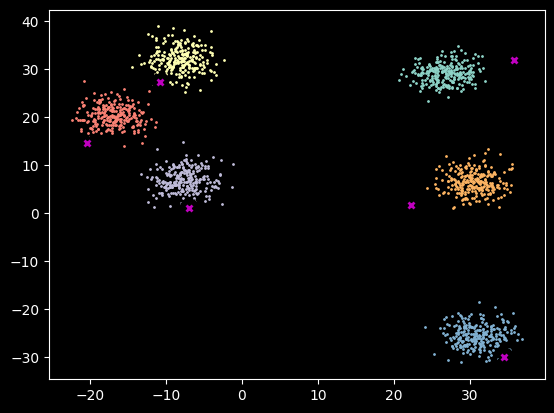

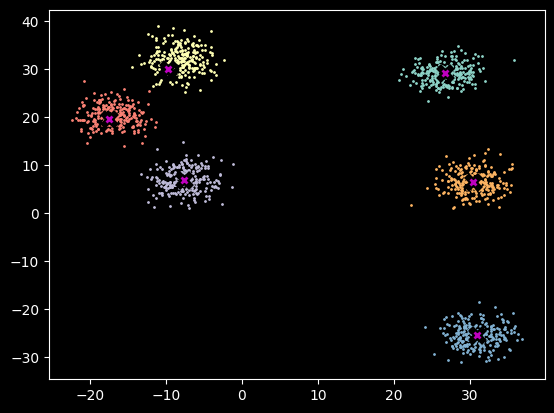

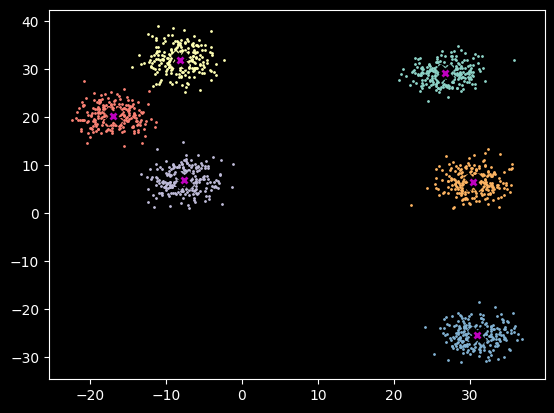

In [13]:
pred_centroids = initialize_centroids(data,n_clusters)
for epoch in range(3):
    plot_data(pred_centroids, data, n_samples)
    centroid_assignments = assign_centroids(pred_centroids,data)
    pred_centroids = update_centroids(centroid_assignments,data)